In [42]:
import os
import cv2 #
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
from tqdm import tqdm

from skimage.exposure import equalize_hist, rescale_intensity
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

In [43]:
BASE_DIR = 'dataset/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
# TEST_DIR = os.path.join(BASE_DIR, 'test'

CLASSES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
NUM_CLASSES = len(CLASSES)

# Parameter untuk pemrosesan gambar
IMG_WIDTH = 256 
IMG_HEIGHT = 256
N_SAMPLES_PER_CLASS_DEMO = 3
N_SAMPLES_PER_CLASS_TRAIN = 2000

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(CLASSES)

LabelEncoder()

In [44]:
def load_sample_images(class_name, num_images, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    """Memuat sejumlah gambar sampel dari kelas tertentu."""
    class_path = os.path.join(TRAIN_DIR, class_name)
    image_files = glob.glob(os.path.join(class_path, '*.jpg'))
    
    loaded_images = []
    selected_files = np.random.choice(image_files, min(num_images, len(image_files)), replace=False)
    
    for img_path in selected_files:
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)
            loaded_images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return loaded_images

def display_images(images_dict, rows=1, main_title=""):
    """Menampilkan beberapa set gambar dengan judul."""
    num_sets = len(images_dict)
    cols = max(len(images) for images in images_dict.values())
    
    fig_height = rows * 3 * len(images_dict)
    fig_width = cols * 3

    fig, axes = plt.subplots(len(images_dict) * rows, cols, figsize=(fig_width, fig_height), squeeze=False)
    fig.suptitle(main_title, fontsize=16)
    
    set_idx = 0
    for title, image_list in images_dict.items():
        for i in range(rows):
            for j, img in enumerate(image_list):
                ax = axes[set_idx * rows + i, j]
                ax.imshow(img)
                if i == 0 and j == 0:
                     ax.set_title(f"{title}\n(Sample {j+1})", fontsize=10)
                else:
                    ax.set_title(f"(Sample {j+1})", fontsize=10)
                ax.axis('off')
            for k in range(len(image_list), cols):
                axes[set_idx * rows + i, k].axis('off')
        set_idx += 1
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Contoh memuat satu gambar untuk demo
sample_image_orig = load_sample_images(CLASSES[0], 1)[0]

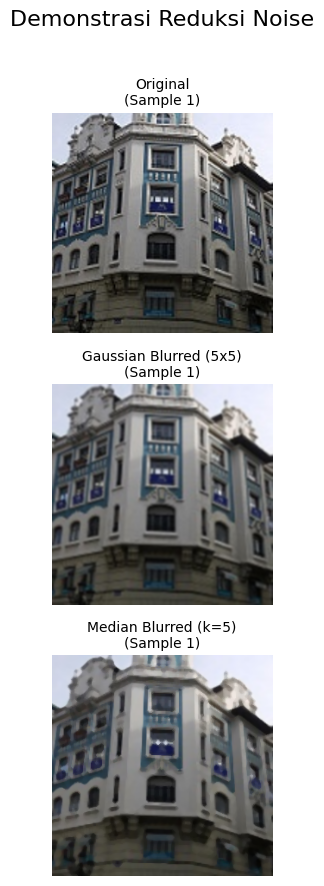

In [45]:
# 1. Reduksi Noise
# Gaussian Filter
gaussian_blurred = cv2.GaussianBlur(sample_image_orig, (5, 5), 0)

# Median Filter
median_blurred = cv2.medianBlur(sample_image_orig, 5)

# Tampilkan Hasil
images_to_show_noise = {
    "Original": [sample_image_orig],
    "Gaussian Blurred (5x5)": [gaussian_blurred],
    "Median Blurred (k=5)": [median_blurred]
}
display_images(images_to_show_noise, main_title="Demonstrasi Reduksi Noise", rows=1)

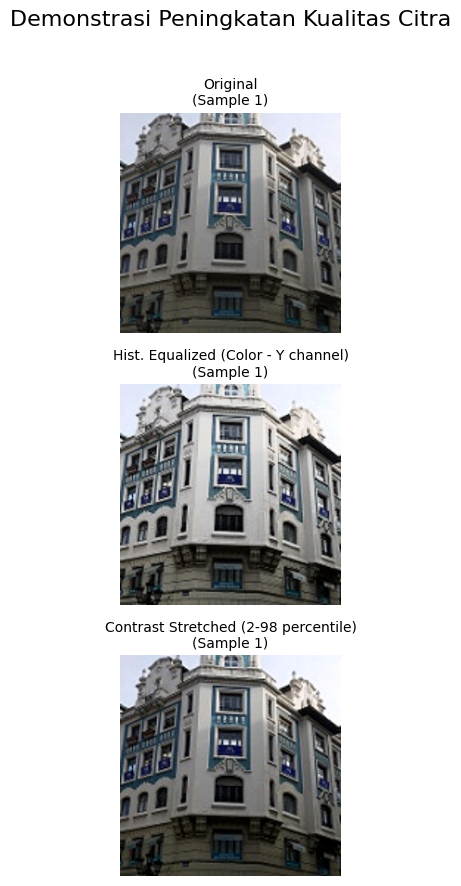

In [46]:
# 2. Peningkatan Kualitas Citra
# Histogram Equalization
gray_orig = cv2.cvtColor(sample_image_orig, cv2.COLOR_RGB2GRAY)
hist_equalized_gray = cv2.equalizeHist(gray_orig)

# Histogram Equalization pada gambar berwarna (per channel)
img_yuv = cv2.cvtColor(sample_image_orig, cv2.COLOR_RGB2YUV)
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
hist_equalized_color = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

# Contrast Stretching (Rescale Intensity)
p_low, p_high = np.percentile(sample_image_orig, (2, 98))
contrast_stretched = rescale_intensity(sample_image_orig, in_range=(p_low, p_high))

# Tampilkan Hasil
images_to_show_enhancement = {
    "Original": [sample_image_orig],
    "Hist. Equalized (Color - Y channel)": [hist_equalized_color],
    "Contrast Stretched (2-98 percentile)": [contrast_stretched]
}
display_images(images_to_show_enhancement, main_title="Demonstrasi Peningkatan Kualitas Citra", rows=1)

In [47]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    """Ekstraksi histogram warna 3D (RGB) dan di-flatten."""
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(image_gray, P=8, R=1, method='uniform'):
    """Ekstraksi Local Binary Patterns dan histogramnya."""
    lbp = local_binary_pattern(image_gray, P, R, method=method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist

def extract_haralick_textures(image_gray):
    """Ekstraksi fitur tekstur Haralick dari GLCM."""
    glcm = graycomatrix(image_gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    asm = graycoprops(glcm, 'ASM').mean()
    
    return np.array([contrast, dissimilarity, homogeneity, energy, correlation, asm])

sample_gray = cv2.cvtColor(sample_image_orig, cv2.COLOR_RGB2GRAY)

print("Contoh Fitur Ekstraksi:")
hist_features = extract_color_histogram(sample_image_orig)
print(f"  Color Histogram features (shape): {hist_features.shape}")

lbp_features = extract_lbp_features(sample_gray)
print(f"  LBP features (shape): {lbp_features.shape}")

haralick_features = extract_haralick_textures(sample_gray)
print(f"  Haralick features (shape): {haralick_features.shape}")

Contoh Fitur Ekstraksi:
  Color Histogram features (shape): (512,)
  LBP features (shape): (10,)
  Haralick features (shape): (6,)


In [48]:
def process_image_for_features(image_rgb):
    """
    Memproses satu gambar RGB:
    1. (Opsional) Terapkan pra-pemrosesan ringan jika diperlukan (misal, blur ringan).
    2. Ekstrak Color Histogram.
    3. Konversi ke Grayscale dan ekstrak LBP.
    4. Gabungkan fitur.
    """
    # 1. Pra-pemrosesan (opsional, contoh: blur ringan untuk stabilitas fitur)
    # image_rgb = cv2.GaussianBlur(image_rgb, (3,3), 0)

    # 2. Ekstrak Color Histogram
    color_hist = extract_color_histogram(image_rgb)
    
    # 3. Ekstrak LBP
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    lbp_hist = extract_lbp_features(image_gray)
    
    # 4. Gabungkan fitur
    combined_features = np.hstack([color_hist, lbp_hist])
    return combined_features

# Memuat data dan mengekstrak fitur
features_list = []
labels_list = []

print(f"Memuat dan mengekstrak fitur dari {N_SAMPLES_PER_CLASS_TRAIN} sampel per kelas...")
for class_name in CLASSES:
    print(f"  Processing class: {class_name}")
    class_path = os.path.join(TRAIN_DIR, class_name)
    image_files = glob.glob(os.path.join(class_path, '*.jpg'))
    
    selected_files = np.random.choice(image_files, min(N_SAMPLES_PER_CLASS_TRAIN, len(image_files)), replace=False)
    
    for img_path in tqdm(selected_files):
        try:
            img_rgb = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
            img_rgb = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))
            
            # Ekstrak fitur
            img_features = process_image_for_features(img_rgb)
            
            features_list.append(img_features)
            labels_list.append(class_name)
        except Exception as e:
            print(f"    Error processing {img_path} untuk fitur: {e}")

X = np.array(features_list)
y_names = np.array(labels_list)

# Encode label nama kelas menjadi numerik
y = label_encoder.transform(y_names)

print(f"\nBentuk matriks fitur X: {X.shape}")
print(f"Bentuk array label y: {y.shape}")

Memuat dan mengekstrak fitur dari 2000 sampel per kelas...
  Processing class: buildings


100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 192.12it/s]


  Processing class: forest


100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 214.18it/s]


  Processing class: glacier


100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 189.17it/s]


  Processing class: mountain


100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 190.10it/s]


  Processing class: sea


100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.01it/s]


  Processing class: street


100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 189.54it/s]



Bentuk matriks fitur X: (12000, 522)
Bentuk array label y: (12000,)


In [49]:
if X.shape[0] > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    print(f"Ukuran X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Ukuran X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Penskalaan Fitur
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("\nPenskalaan fitur selesai.")
else:
    print("Tidak ada fitur yang diekstrak. Tidak dapat melanjutkan.")

Ukuran X_train: (9000, 522), y_train: (9000,)
Ukuran X_test: (3000, 522), y_test: (3000,)

Penskalaan fitur selesai.


In [50]:
if 'X_train_scaled' in locals() and X_train_scaled.shape[0] > 0:
    print("Melatih model Support Vector Machine (SVM)...")
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    # model = SVC(kernel='rbf', C=1.0, random_state=42, probability=True, class_weight='balanced')
    
    model.fit(X_train_scaled, y_train)
    print("Pelatihan model selesai.")
else:
    print("Data training tidak tersedia. Model tidak dilatih.")

Melatih model Support Vector Machine (SVM)...
Pelatihan model selesai.



Mengevaluasi model...
Akurasi Model pada Test Set: 69.23%

Laporan Klasifikasi:
              precision    recall  f1-score   support

   buildings       0.61      0.54      0.57       500
      forest       0.90      0.93      0.92       500
     glacier       0.69      0.74      0.71       500
    mountain       0.64      0.63      0.64       500
         sea       0.63      0.59      0.61       500
      street       0.68      0.71      0.69       500

    accuracy                           0.69      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.69      0.69      0.69      3000



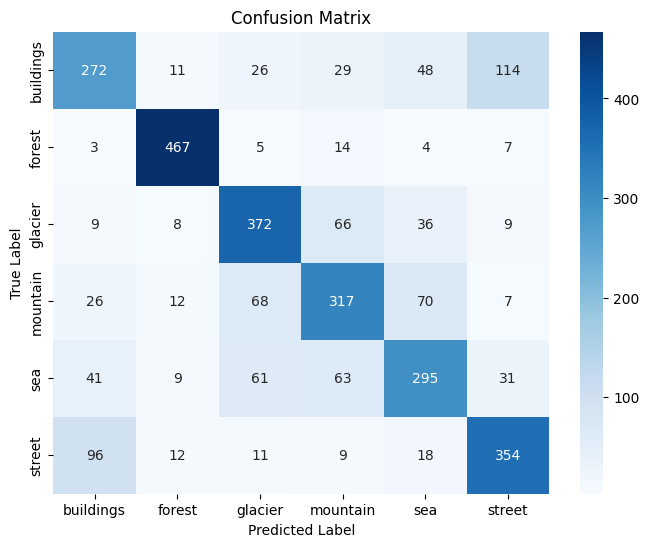

In [51]:
if 'model' in locals() and 'X_test_scaled' in locals() and X_test_scaled.shape[0] > 0:
    print("\nMengevaluasi model...")
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Akurasi Model pada Test Set: {accuracy*100:.2f}%")

    print("\nLaporan Klasifikasi:")
    target_names_report = label_encoder.inverse_transform(np.unique(np.concatenate((y_test, y_pred))))
    print(classification_report(y_test, y_pred, target_names=target_names_report, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(np.concatenate((y_test, y_pred))))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names_report, yticklabels=target_names_report)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("Model tidak dilatih atau data tes tidak tersedia. Evaluasi tidak dapat dilakukan.")

Visualisasi Contoh Hasil Ekstraksi Fitur


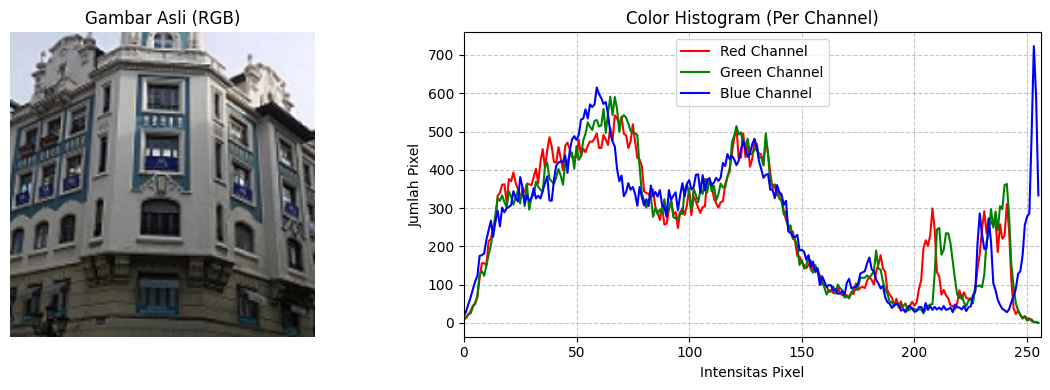

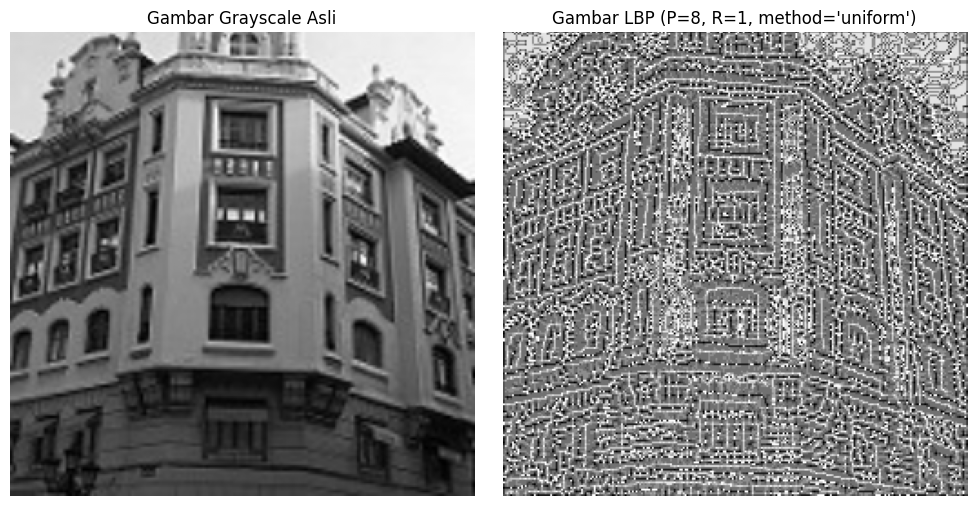

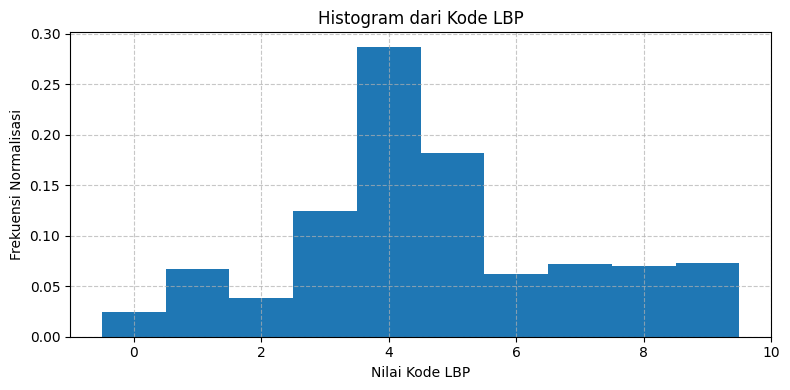

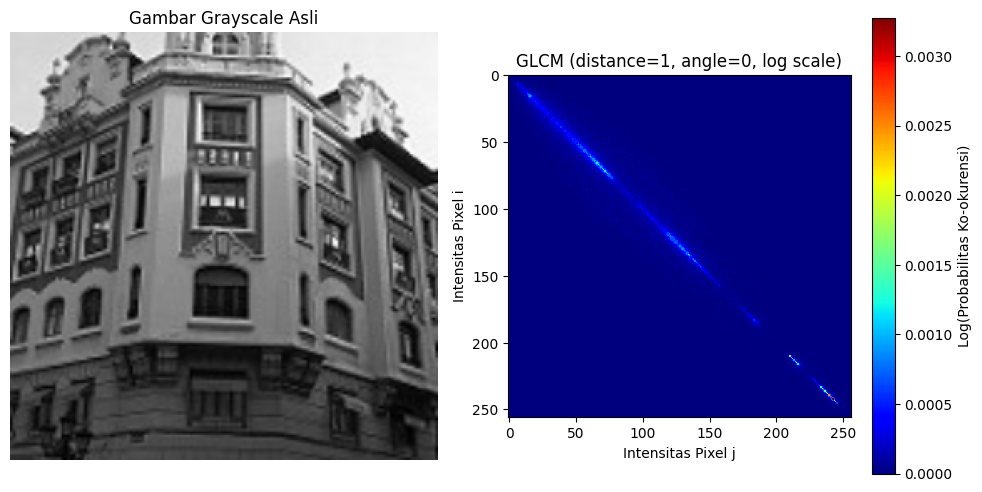


Contoh Fitur Haralick yang Diekstrak:
  Contrast: 356.6442
  Dissimilarity: 11.4395
  Homogeneity: 0.2044
  Energy: 0.0159
  Correlation: 0.9522
  ASM: 0.0003


In [52]:
print("Visualisasi Contoh Hasil Ekstraksi Fitur")

# --- 1. Visualisasi Color Histogram ---
plt.figure(figsize=(12, 4))
colors = ('r', 'g', 'b')
channel_names = ('Red', 'Green', 'Blue')

plt.subplot(1, 2, 1)
plt.imshow(sample_image_orig)
plt.title("Gambar Asli (RGB)")
plt.axis('off')

plt.subplot(1, 2, 2)
for i, color in enumerate(colors):
    hist = cv2.calcHist([sample_image_orig], [i], None, [256], [0, 256])
    plt.plot(hist, color=color, label=f'{channel_names[i]} Channel')
plt.title("Color Histogram (Per Channel)")
plt.xlabel("Intensitas Pixel")
plt.ylabel("Jumlah Pixel")
plt.xlim([0, 256])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- 2. Visualisasi Gambar LBP ---
P_vis = 8 
R_vis = 1 
method_vis = 'uniform'

lbp_image = local_binary_pattern(sample_gray, P_vis, R_vis, method=method_vis)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_gray, cmap='gray')
plt.title("Gambar Grayscale Asli")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title(f"Gambar LBP (P={P_vis}, R={R_vis}, method='{method_vis}')")
plt.axis('off')
plt.tight_layout()
plt.show()

# Histogram dari LBP
n_bins_lbp_vis = int(lbp_image.max() + 1)
hist_lbp_vis, _ = np.histogram(lbp_image.ravel(), bins=n_bins_lbp_vis, range=(0, n_bins_lbp_vis), density=True)

plt.figure(figsize=(8, 4))
plt.bar(range(n_bins_lbp_vis), hist_lbp_vis, width=1.0, align='center')
plt.title("Histogram dari Kode LBP")
plt.xlabel("Nilai Kode LBP")
plt.ylabel("Frekuensi Normalisasi")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- 3. Visualisasi GLCM (Gray-Level Co-occurrence Matrix) ---
glcm_vis = graycomatrix(sample_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

glcm_single = glcm_vis[:, :, 0, 0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_gray, cmap='gray')
plt.title("Gambar Grayscale Asli")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.log1p(glcm_single), cmap='jet', interpolation='nearest') # log1p(x) = log(1+x)
plt.title("GLCM (distance=1, angle=0, log scale)")
plt.xlabel("Intensitas Pixel j")
plt.ylabel("Intensitas Pixel i")
plt.colorbar(label="Log(Probabilitas Ko-okurensi)")
plt.tight_layout()
plt.show()

haralick_features_vis = extract_haralick_textures(sample_gray)
print("\nContoh Fitur Haralick yang Diekstrak:")
haralick_names = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM']
for name, val in zip(haralick_names, haralick_features_vis):
    print(f"  {name}: {val:.4f}")